🔗 Number of nodes: 2274
🔁 Number of fraudulent edges (transactions): 1142

🚩 Top suspicious senders:
C1305486145: 1 transactions
C840083671: 1 transactions
C1420196421: 1 transactions
C2101527076: 1 transactions
C137533655: 1 transactions


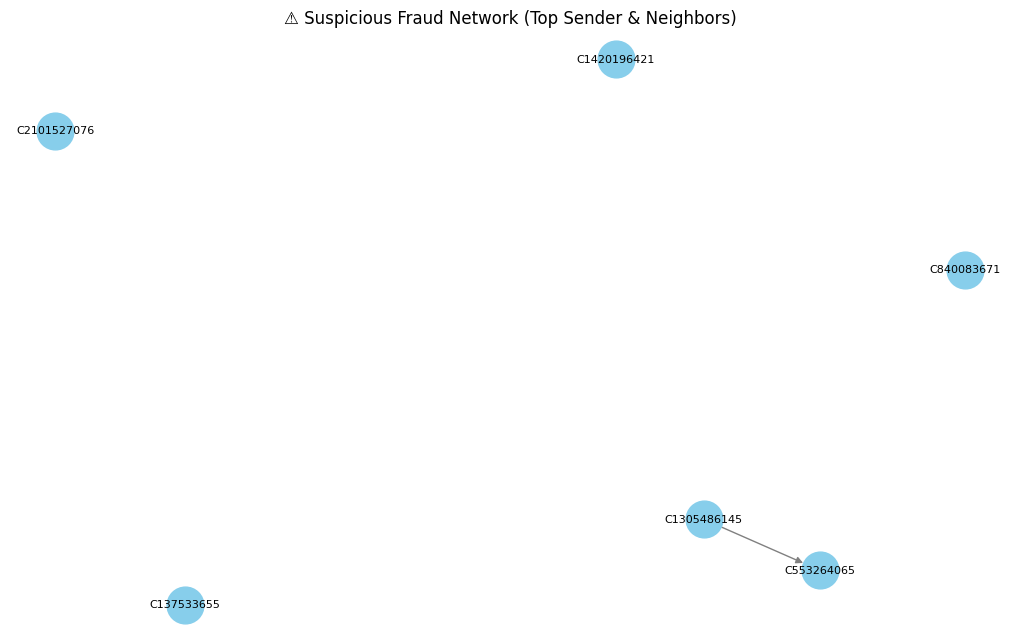

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

#  Load data (replace with your cleaned path if needed)
df = pd.read_csv('C:/Users/austi/Project/Advanced-Financial-Fraud-detection/data/paysim_cleaned.csv')
# Filter for fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Create a directed graph
G = nx.from_pandas_edgelist(
    fraud_df,
    source='nameOrig',
    target='nameDest',
    edge_attr='amount',
    create_using=nx.DiGraph()
)

#  Analyze the graph
print(f"🔗 Number of nodes: {G.number_of_nodes()}")
print(f"🔁 Number of fraudulent edges (transactions): {G.number_of_edges()}")

#  Find top suspicious nodes (most outgoing fraud transactions)
top_senders = sorted(G.out_degree, key=lambda x: x[1], reverse=True)[:5]
print("\n🚩 Top suspicious senders:")
for sender, count in top_senders:
    print(f"{sender}: {count} transactions")

# Visualize (optional)
plt.figure(figsize=(10, 6))
subgraph = G.subgraph([node for node, _ in top_senders] + list(G.successors(top_senders[0][0])))
pos = nx.spring_layout(subgraph, k=0.5)
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=700, font_size=8)
plt.title("⚠️ Suspicious Fraud Network (Top Sender & Neighbors)")
plt.show()


# Email Alert System


In [2]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

def send_fraud_alert(transaction):
    sender_email = "cherianaustin16@gmail.com"
    receiver_email = "austincherian12@gmail.com"
    app_password = "sord qxez diaf fxcs"  # App-specific password from Gmail

    subject = "🚨 Fraud Alert: Suspicious Transaction Detected"
    body = f"""
    ⚠️ Suspicious Transaction Alert ⚠️

    Transaction Details:
    - Transaction ID: {transaction.get('transactionID', 'N/A')}
    - Sender: {transaction['nameOrig']}
    - Receiver: {transaction['nameDest']}
    - Amount: {transaction['amount']}
    - Type: {transaction['type']}

    This transaction was flagged as potentially fraudulent.
    """

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject
    message.attach(MIMEText(body, "plain"))

    try:
        server = smtplib.SMTP("smtp.gmail.com", 587)
        server.starttls()
        server.login(sender_email, app_password)
        server.sendmail(sender_email, receiver_email, message.as_string())
        server.quit()
        print("✅ Email alert sent successfully.")
    except Exception as e:
        print("❌ Failed to send email:", e)

In [6]:
#Merge original data + all predictions
df_raw = pd.read_csv("../data/paysim_cleaned.csv")
df_preds = pd.read_csv("../data/df_with_predictions.csv")

df_raw = df_raw.reset_index(drop=True)
df_preds = df_preds.reset_index(drop=True)

df_combined = pd.concat([df_raw, df_preds], axis=1)

print(df_combined['Pred_RF'].value_counts())

def trigger_fraud_alerts(df, model_col='Pred_RF', limit=3):
    if model_col not in df.columns:
        print(f"❌ Column '{model_col}' not found in DataFrame.")
        return
    
    fraud_rows = df[df[model_col] == 1].head(limit)
    print(f"🔍 Found {len(fraud_rows)} fraud(s) predicted by {model_col}")

    if fraud_rows.empty:
        print("✅ No frauds predicted to alert.")
        return

    for i, (_, row) in enumerate(fraud_rows.iterrows(), 1):
        print(f"📤 Sending alert #{i} for sender: {row.get('nameOrig', 'N/A')} | Amount: {row.get('amount', 0)}")
        send_fraud_alert(row)

    print("✅ All alerts sent.")

Pred_RF
0.0    314331
1.0       242
Name: count, dtype: int64


In [8]:
trigger_fraud_alerts(df_combined, model_col='Pred_XGB', limit=3)


🔍 Found 3 fraud(s) predicted by Pred_XGB
📤 Sending alert #1 for sender: C8197402 | Amount: amount     58516.68
amount    328115.31
Name: 1878, dtype: object
✅ Email alert sent successfully.
📤 Sending alert #2 for sender: C486662053 | Amount: amount      7020.05
amount    103021.64
Name: 1938, dtype: object
✅ Email alert sent successfully.
📤 Sending alert #3 for sender: C1877240674 | Amount: amount      6683.73
amount    425885.96
Name: 1975, dtype: object
✅ Email alert sent successfully.
✅ All alerts sent.
